In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df=pd.read_csv('/content/drive/MyDrive/output.csv')

<ipython-input-4-14b04c33aebc>:1: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/content/drive/MyDrive/output.csv')


In [5]:
df.shape

(15184, 227)

In [6]:
df = df.drop_duplicates()
df = df.drop(df[df['Rjb_km'] == -999 ].index)
df = df.drop(df[df['Rjb_km'] > 1500 ].index)
df = df.drop(df[df['Rjb_km'] == -999 ].index)
# df = df.drop(df[df['HypD (km)'] <= 0 ].index)

In [7]:
df.head()

,NGAsubRSN,DatabaseRegion,NGAsubEQID,NGAsubSSN,Earthquake_Name,YEAR,MODY,HRMN,Earthquake_Magnitude,Hypocenter_Latitude_deg,...,T8pt500S,T9pt000S,T9pt500S,T10pt000S,T11pt000S,T12pt000S,T13pt000S,T14pt000S,T15pt000S,T20pt000S
0,1000002,Alaska,1000001,1000002,Aleutian_Isl-Alaska,2014,623,2053,7.96,51.6928,...,0.000415,0.000395,0.000405,0.000390,0.000336,0.000332,0.000263,0.000215,0.000187,0.000119
1,1000008,Alaska,1000001,1000008,Aleutian_Isl-Alaska,2014,623,2053,7.96,51.6928,...,0.000164,0.000193,0.000212,0.000196,0.000187,0.000199,0.000218,0.000237,0.000216,0.000084
2,1000040,Alaska,1000003,1000008,3316471,2011,624,309,7.28,51.9805,...,0.000590,0.000511,0.000469,0.000413,0.000460,0.000355,0.000286,0.000223,0.000158,0.000070
3,1000056,Alaska,1000004,1000008,2587660,2007,1219,930,7.21,51.3510,...,0.000124,0.000104,0.000092,0.000093,0.000124,0.000125,0.000148,0.000138,0.000164,0.000172
4,1000069,Alaska,1000005,1000005,4224881,2013,830,1625,7.00,51.6230,...,0.000054,0.000049,0.000040,0.000033,0.000030,0.000037,0.000039,0.000045,0.000049,0.000041


In [8]:
df['log Rjb'] = np.log10(df['Rjb_km'])

In [9]:
d = {}
i = 1
for row in df['DatabaseRegion']:
  if row not in d:
    d[row] = i
    i += 1

In [10]:
d

{'Alaska': 1,
 'Cascadia': 2,
 'CentralAmerica&Mexico': 3,
 'Japan': 4,
 'SouthAmerica': 5,
 'Taiwan': 6}

In [11]:
df['regionFlag'] = df['DatabaseRegion'].map(d)

In [12]:
df.columns

Index(['NGAsubRSN', 'DatabaseRegion', 'NGAsubEQID', 'NGAsubSSN',
       'Earthquake_Name', 'YEAR', 'MODY', 'HRMN', 'Earthquake_Magnitude',
       'Hypocenter_Latitude_deg',
       ...
       'T9pt500S', 'T10pt000S', 'T11pt000S', 'T12pt000S', 'T13pt000S',
       'T14pt000S', 'T15pt000S', 'T20pt000S', 'log Rjb', 'regionFlag'],
      dtype='object', length=229)

In [14]:
import re

X = df[['Earthquake_Magnitude','Rjb_km','log Rjb','Vs30_Selected_for_Analysis_m_s','regionFlag','Intra_Inter_Flag']]
# X = df[['Earthquake_Magnitude','Rjb_km','log Rjb','Vs30_Selected_for_Analysis_m_s','regionFlag']]


pattern = re.compile(r'^T(\d+)pt(\d{3})S$')

matching_columns = []
t = []

for col in df.columns:
    match = pattern.match(col)
    if match:

        minutes = int(match.group(1))
        seconds = int(match.group(2)) / 1000.0

        total_seconds = minutes + seconds


        if 0.01 <= total_seconds <= 20.000:
            matching_columns.append(col)
            t.append(total_seconds)
y = df[matching_columns]

y = np.log10(y.replace(0, np.nan) + 1e-10)

In [15]:
t

[0.01,
 0.02,
 0.022,
 0.025,
 0.029,
 0.03,
 0.032,
 0.035,
 0.036,
 0.04,
 0.042,
 0.044,
 0.045,
 0.046,
 0.048,
 0.05,
 0.055,
 0.06,
 0.065,
 0.067,
 0.07,
 0.075,
 0.08,
 0.085,
 0.09,
 0.095,
 0.1,
 0.11,
 0.12,
 0.13,
 0.133,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.22,
 0.24,
 0.25,
 0.26,
 0.28,
 0.29,
 0.3,
 0.32,
 0.34,
 0.35,
 0.36,
 0.38,
 0.4,
 0.42,
 0.44,
 0.45,
 0.46,
 0.48,
 0.5,
 0.55,
 0.6,
 0.65,
 0.667,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 2.0,
 2.2,
 2.4,
 2.5,
 2.6,
 2.8,
 3.0,
 3.2,
 3.4,
 3.5,
 3.6,
 3.8,
 4.0,
 4.2,
 4.4,
 4.6,
 4.8,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 20.0]

In [16]:
y.shape

(15184, 111)

In [17]:
X.shape

(15184, 6)

In [18]:
from sklearn.model_selection import train_test_split
import sklearn as sk

<Axes: >

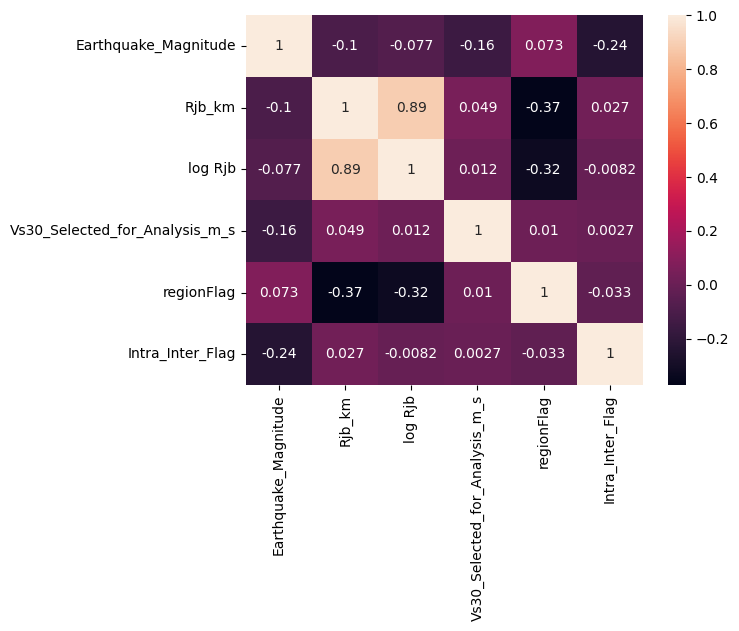

In [19]:
import seaborn as sns

sns.heatmap(df[['Earthquake_Magnitude','Rjb_km','log Rjb','Vs30_Selected_for_Analysis_m_s','regionFlag','Intra_Inter_Flag']].corr(), annot = True)
# sns.heatmap(df[['Earthquake_Magnitude','Rjb_km','log Rjb','Vs30_Selected_for_Analysis_m_s','regionFlag']].corr(), annot = True)

In [20]:
n_samples, n_feature = X.shape
n_s, n_labels = y.shape

print(n_samples, n_feature)
print(n_s, n_labels)

batch_size = 32


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state=51)

X_train = torch.tensor(X_train.astype(np.float32).values)
X_test = torch.tensor(X_test.astype(np.float32).values)
y_train = torch.tensor(y_train.astype(np.float32).values)
y_test = torch.tensor(y_test.astype(np.float32).values)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

15184 6
15184 111


**ANN Model**

In [21]:
class ANN(nn.Module):
  def __init__(self,n_input_featurs, hidden_layer, n_output_labels):
    super(ANN, self).__init__()
    self.linear1 = nn.Linear(n_input_featurs, hidden_layer)
    self.linear2 = nn.Linear(hidden_layer, n_output_labels)

  def forward(self, x):
    x = F.leaky_relu(self.linear1(x), negative_slope=0.1)
    x = self.linear2(x)

    return x

 **CVAE Model**

In [23]:
class Encoder(nn.Module):
  def __init__(self, input_dim, latent_dim):
    super(Encoder, self).__init__()
    self.l1 = nn.Linear(input_dim, 32)
    self.l11 = nn.Linear(32, 8)
    # dividing the data into probabilistic distribution
    self.l2_mean = nn.Linear(8, latent_dim)
    self.l2_logvar = nn.Linear(8, latent_dim)

  def forward(self, x):
    x = F.leaky_relu(self.l1(x), negative_slope=0.1)
    x = F.leaky_relu(self.l11(x), negative_slope=0.1)
    mean = self.l2_mean(x)
    logvar = self.l2_logvar(x)

    return mean, logvar


In [24]:
class Decoder(nn.Module):
  def __init__(self, latent_dim, output_dim):
    super(Decoder, self).__init__()
    self.l1 = nn.Linear(latent_dim, 8)
    self.l11 = nn.Linear(8, 32)
    self.l2 = nn.Linear(32, output_dim)

  def forward(self, x):
    x = F.leaky_relu(self.l1(x), negative_slope=0.1)
    x = F.leaky_relu(self.l11(x), negative_slope=0.1)
    x_recon = self.l2(x)

    return x_recon


In [25]:
class VAE(nn.Module):
  def __init__(self, input_dim, latent_dim, output_dim):
    super(VAE, self).__init__()
    self.encoder = Encoder(input_dim, latent_dim)
    self.decoder = Decoder(latent_dim, output_dim)

  def forward(self, x):
    mean, logvar = self.encoder(x)
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)   # this takes out a random numbers to create a tensor with mean = 0 and std dev = 1
    z = mean + eps * std
    x_recon = self.decoder(z)    # this is the reconstrucrted Response Spectra (RS)

    return x_recon, mean, logvar

In [26]:
def VAE_loss(x_recon, x, mean, logvar):
  recon_loss = F.mse_loss(x_recon, x, reduction='sum')   # MSE loss between reconstructed RS and actual RS
  kl_d = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())   # this is the KL Divergence Loss function
  return recon_loss + kl_d   # total Loss

-------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
input_dim_ANN =  n_feature  # 5 parameters on which the RS is to be predicted
output_dim = n_labels  # output contains log PSA for 111 time stamps

model_ANN = ANN(input_dim_ANN, 10, output_dim)


learning_rate1 = 0.001
criterion = nn.MSELoss()
optimizer1 = optim.AdamW(model_ANN.parameters(), lr = learning_rate1)

In [28]:
n_epochs = 100

for epoch in range(n_epochs):
  for i, data in enumerate(train_loader):
    input, output = data
    y_pred = model_ANN(input)
    loss = criterion(y_pred, output)

    loss.backward()

    optimizer1.step()
    optimizer1.zero_grad()

    if (i+1)%200 == 0:
      print(f'epoch: {epoch+1}/{n_epochs}, step:{i+1}/{len(train_loader)} loss: {loss.item():.4f}')

epoch: 1/100, step:200/404 loss: 36.6022
epoch: 1/100, step:400/404 loss: 6.1012
epoch: 2/100, step:200/404 loss: 1.5569
epoch: 2/100, step:400/404 loss: 2.3245
epoch: 3/100, step:200/404 loss: 0.5349
epoch: 3/100, step:400/404 loss: 0.7227
epoch: 4/100, step:200/404 loss: 0.5689
epoch: 4/100, step:400/404 loss: 0.6728
epoch: 5/100, step:200/404 loss: 0.7078
epoch: 5/100, step:400/404 loss: 0.5080
epoch: 6/100, step:200/404 loss: 0.6386
epoch: 6/100, step:400/404 loss: 0.5010
epoch: 7/100, step:200/404 loss: 0.4903
epoch: 7/100, step:400/404 loss: 1.1062
epoch: 8/100, step:200/404 loss: 0.5912
epoch: 8/100, step:400/404 loss: 0.5494
epoch: 9/100, step:200/404 loss: 0.8377
epoch: 9/100, step:400/404 loss: 0.7154
epoch: 10/100, step:200/404 loss: 0.9231
epoch: 10/100, step:400/404 loss: 0.4193
epoch: 11/100, step:200/404 loss: 0.4759
epoch: 11/100, step:400/404 loss: 0.4935
epoch: 12/100, step:200/404 loss: 0.5219
epoch: 12/100, step:400/404 loss: 0.4910
epoch: 13/100, step:200/404 loss:

In [ ]:
path = '/content/drive/MyDrive/SEISMIC MODELS/VAE/ANN_model_Subduction.pth'
torch.save(model_ANN,path)

In [29]:
model_ANN.eval()
with torch.no_grad():
  y_pred = model_ANN(X_test)

In [30]:
y_p = y_pred.detach().numpy()
y_t = y_test.detach().numpy()

In [31]:
from sklearn.metrics import r2_score

# Calculate R^2 score for the first dataframe

for i in range(111):
  r2_score_1 = r2_score(y_p[:,i], y_t[:,i])
  print(f"r2 score for col {i+1}:", r2_score_1)


r2 score for col 1: 0.7953646302796672
r2 score for col 2: 0.7950476634744039
r2 score for col 3: 0.7914976903859
r2 score for col 4: 0.7938484093580985
r2 score for col 5: 0.7935638154100702
r2 score for col 6: 0.7926861153692403
r2 score for col 7: 0.7860274901478204
r2 score for col 8: 0.791766858078831
r2 score for col 9: 0.7906125176186793
r2 score for col 10: 0.7886284368463818
r2 score for col 11: 0.7851922136861997
r2 score for col 12: 0.7832553971988303
r2 score for col 13: 0.7831145857483959
r2 score for col 14: 0.7757905802185799
r2 score for col 15: 0.7790261462139909
r2 score for col 16: 0.7754643267110668
r2 score for col 17: 0.7747891299654025
r2 score for col 18: 0.7695344216063803
r2 score for col 19: 0.7630281373073087
r2 score for col 20: 0.7591847321372454
r2 score for col 21: 0.7496221737980311
r2 score for col 22: 0.7525280816975696
r2 score for col 23: 0.744612647125763
r2 score for col 24: 0.7410596675182449
r2 score for col 25: 0.7310549402772468
r2 score for c

In [45]:
r2_score_1 = r2_score(y_p[:,:], y_t[:,:])
print(f"r2 score for ANN:", r2_score_1)

r2 score for ANN: 0.7839584535238062


===================================================================================================================

In [32]:
input_dim = n_labels
latent_dim = 3
output_dim = n_labels
learning_rate = 0.01
epochs = 30

model = VAE(input_dim, latent_dim, output_dim)
optimizer = optim.AdamW(model.parameters(), lr = learning_rate)

In [33]:
l = []
for epoch in range(epochs):
  model.train()
  epoch_loss = 0

  for i, data in enumerate(train_loader):
    _, output = data

    optimizer.zero_grad()

    x_recon, mean, logvar = model(output)

    loss = VAE_loss(x_recon, output, mean, logvar)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

    if (i+1)%200 == 0:
      print(f'epoch: {epoch+1}/{epochs}, step:{i+1}/{len(train_loader)} loss: {loss.item():.4f}')
      l.append(loss.item())

  print(f'Epoch {epoch+1} completed. Average Loss: {epoch_loss / len(train_loader):.4f}')

epoch: 1/30, step:200/404 loss: 471.2450
epoch: 1/30, step:400/404 loss: 372.0646
Epoch 1 completed. Average Loss: 1118.9584
epoch: 2/30, step:200/404 loss: 309.9283
epoch: 2/30, step:400/404 loss: 299.8246
Epoch 2 completed. Average Loss: 306.5487
epoch: 3/30, step:200/404 loss: 296.5370
epoch: 3/30, step:400/404 loss: 261.5830
Epoch 3 completed. Average Loss: 285.9143
epoch: 4/30, step:200/404 loss: 300.1345
epoch: 4/30, step:400/404 loss: 283.5815
Epoch 4 completed. Average Loss: 281.5618
epoch: 5/30, step:200/404 loss: 273.3148
epoch: 5/30, step:400/404 loss: 251.6711
Epoch 5 completed. Average Loss: 268.2741
epoch: 6/30, step:200/404 loss: 261.4437
epoch: 6/30, step:400/404 loss: 301.7116
Epoch 6 completed. Average Loss: 272.3793
epoch: 7/30, step:200/404 loss: 255.4645
epoch: 7/30, step:400/404 loss: 242.1634
Epoch 7 completed. Average Loss: 258.5979
epoch: 8/30, step:200/404 loss: 249.4934
epoch: 8/30, step:400/404 loss: 280.4208
Epoch 8 completed. Average Loss: 255.5813
epoch: 

In [34]:
model.eval()

with torch.no_grad():
  y_pv,_,_ = model(y_pred)

y_p_vae = y_pv.detach().numpy()

In [ ]:
path_vae = '/content/drive/MyDrive/SEISMIC MODELS/VAE/VAE_model_Subduction.pth'


In [ ]:
torch.save(model, path_vae)

In [ ]:
model = torch.load(path_vae)

In [35]:
from sklearn.metrics import r2_score

# Calculate R^2 score for the first dataframe
r = 0

for i in range(111):
  r2_score_1 = r2_score(y_p_vae[:,i], y_t[:,i])
  print(f"r2 score for col {i+1}:", r2_score_1)

r2 score for col 1: 0.7738457076271926
r2 score for col 2: 0.771941518137369
r2 score for col 3: 0.7711898407944919
r2 score for col 4: 0.7704352319873939
r2 score for col 5: 0.7691837045408372
r2 score for col 6: 0.7689769040322694
r2 score for col 7: 0.7680543398584148
r2 score for col 8: 0.7664969576633874
r2 score for col 9: 0.7659721454182358
r2 score for col 10: 0.7631411496253897
r2 score for col 11: 0.7615263908927459
r2 score for col 12: 0.7586511103584686
r2 score for col 13: 0.757534032141833
r2 score for col 14: 0.7569078475557502
r2 score for col 15: 0.7553313572718162
r2 score for col 16: 0.7538370829927105
r2 score for col 17: 0.7471118250251674
r2 score for col 18: 0.7427260084340334
r2 score for col 19: 0.7376747173999818
r2 score for col 20: 0.7353379066645002
r2 score for col 21: 0.7303947888202154
r2 score for col 22: 0.7271268050115749
r2 score for col 23: 0.7256003653952721
r2 score for col 24: 0.7208275705244616
r2 score for col 25: 0.7151257637731939
r2 score fo

In [46]:
r2_score_1 = r2_score(y_p_vae[:,:], y_t[:,:])
print(f"r2 score for VAE:", r2_score_1)

r2 score for VAE: 0.7735010144201911


**PLOTS**

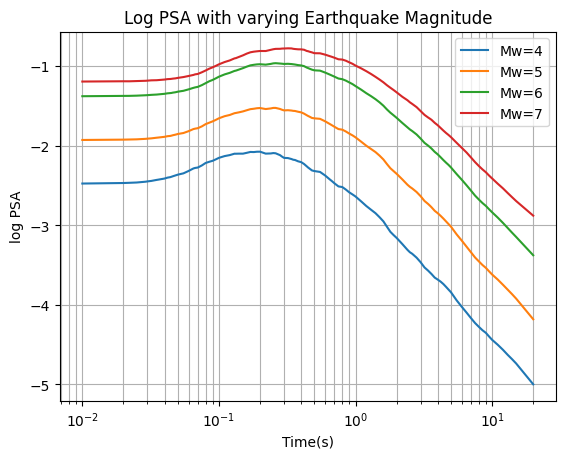

In [48]:
l=[]

model_ANN.eval()
model.eval()

rjb = 25
region = 3
intra_inter = 0

r = [4,rjb,np.log10(rjb),600,region,intra_inter]
r1 = [5,rjb,np.log10(rjb), 600,region,intra_inter]
r2 = [6,rjb,np.log10(rjb), 600,region,intra_inter]
r3 = [7,rjb,np.log10(rjb), 600,region,intra_inter]


l.append(r)
l.append(r1)
l.append(r2)
l.append(r3)


l = torch.tensor(l, dtype=torch.float32)


with torch.no_grad():
  rp = model_ANN(l)
with torch.no_grad():
  prs,_,_ = model(rp)

plt.plot(t, prs[0][:], label='Mw=4')
plt.plot(t, prs[1][:], label='Mw=5')
plt.plot(t, prs[2][:], label='Mw=6')
plt.plot(t, prs[3][:], label='Mw=7')

plt.xlabel('Time(s)')
plt.ylabel('log PSA')
plt.xscale('log')
plt.grid(True, which = 'both')
plt.title('Log PSA with varying Earthquake Magnitude')

plt.legend()

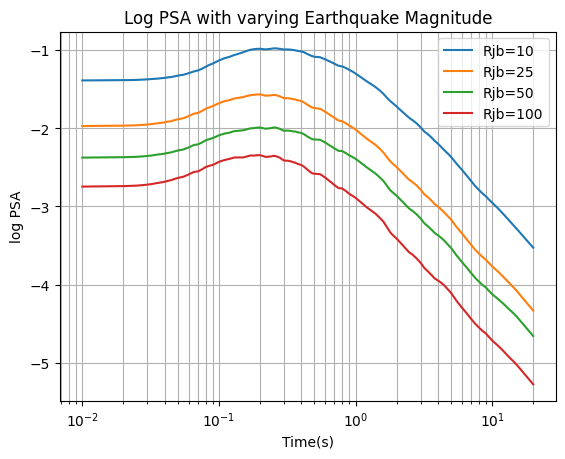

In [49]:
l=[]

model_ANN.eval()
model.eval()

rjb = [10,25,50,100]
region = 1
intra_inter = 1

r = [5,rjb[0],np.log10(rjb[0]),600,region,intra_inter]
r1 = [5,rjb[1],np.log10(rjb[1]), 600,region,intra_inter]
r2 = [5,rjb[2],np.log10(rjb[2]), 600,region,intra_inter]
r3 = [5,rjb[3],np.log10(rjb[3]), 600,region,intra_inter]


l.append(r)
l.append(r1)
l.append(r2)
l.append(r3)


l = torch.tensor(l, dtype=torch.float32)


with torch.no_grad():
  rp = model_ANN(l)
with torch.no_grad():
  prs,_,_ = model(rp)

plt.plot(t, prs[0][:], label=f'Rjb={rjb[0]}')
plt.plot(t, prs[1][:], label=f'Rjb={rjb[1]}')
plt.plot(t, prs[2][:], label=f'Rjb={rjb[2]}')
plt.plot(t, prs[3][:], label=f'Rjb={rjb[3]}')

plt.xlabel('Time(s)')
plt.ylabel('log PSA')
plt.xscale('log')
plt.grid(True, which = 'both')
plt.title('Log PSA with varying Earthquake Magnitude')

plt.legend()

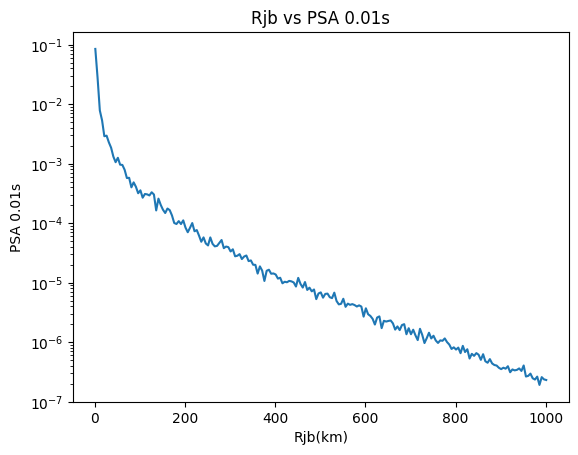

In [43]:
l = []

rjb = np.arange(1,1005,5)
region = 1
intra_inter = 1


for d in rjb:
  r = [4,d,np.log10(d),600,region,intra_inter]
  l.append(r)

l = torch.tensor(l, dtype = torch.float32)

with torch.no_grad():
  rs = model_ANN(l)

with torch.no_grad():
  prs,_,_ = model(rs)

plt.plot(l[:, 1], 10**prs[:, 0])
plt.xlabel('Rjb(km)')
plt.ylabel('PSA 0.01s')
plt.yscale('log')
plt.title('Rjb vs PSA 0.01s')
plt.show()

In [ ]:
intra = df[df['Intra_Inter_Flag'] == 1]
inter = df[df['Intra_Inter_Flag'] == 0]